In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer


numerical_features = [
    "n_items", "total_price", "total_freight", "avg_price",
    "payment_value", "seller_avg_score_past",
    "purchase_to_estimated_days"
]
ordinal_linear = ["payment_installments"]
ordinal_cyclic = ["purchase_month", "purchase_dow"]
categorical_features = ["main_payment_type", "same_state", "customer_state", "seller_state"]
df=pd.read_csv('../data/df.csv',index_col=False)
X = df.drop(columns=["is_late"])
y = df["is_late"]
groups = df["customer_unique_id"]

def encode_cyclic_features(df):
    df = df.copy()
    return pd.DataFrame({
        "month_sin": np.sin(2 * np.pi * df["purchase_month"] / 12),
        "month_cos": np.cos(2 * np.pi * df["purchase_month"] / 12),
        "dow_sin": np.sin(2 * np.pi * df["purchase_dow"] / 7),
        "dow_cos": np.cos(2 * np.pi * df["purchase_dow"] / 7),
    })

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features + ordinal_linear),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("cyclic", FunctionTransformer(encode_cyclic_features), ordinal_cyclic)
    ]
)

In [14]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import (
    f1_score, classification_report, accuracy_score,
    precision_score, recall_score, confusion_matrix, roc_auc_score
)
import numpy as np
import xgboost as xgb
import joblib
from tqdm import tqdm
from copy import deepcopy

param_grid = {
    "learning_rate": [0.01, 0.03,0.05],
    "n_estimators": [5000],
    "seed": [0],
    "reg_alpha": [0, 1e-2, 1, 10],
    "reg_lambda": [0, 1e-2, 1, 10,100],
    "max_depth": [1, 3, 10],
    "colsample_bytree": [0.9],
    "subsample": [0.66],
    "scale_pos_weight": [8, 12],
    "missing": [np.nan],
}
param_list = list(ParameterGrid(param_grid))
print(f"Total combinations per run: {len(param_list)}")

all_test_f1 = []
overall_best_test_f1 = -1.0
overall_best_run_info = None

for i in range(1, 4):
    rs = 42 * i
    print(f"\n====== Outer split run {i}/3 (random_state={rs}) ======")
    X_other, X_test, y_other, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=rs,
        stratify=y
    )
    X_train_raw, X_val_raw, y_train, y_val = train_test_split(
        X_other, y_other,
        test_size=0.25,
        random_state=rs,
        stratify=y_other
    )
    preprocessor.fit(X_train_raw)
    X_train = preprocessor.transform(X_train_raw)
    X_val   = preprocessor.transform(X_val_raw)
    X_test_pre = preprocessor.transform(X_test)

    print("Train shape:", X_train.shape)
    print("Val shape  :", X_val.shape)
    print("Test shape :", X_test_pre.shape)

    results = []
    best_model_run  = None
    best_params_run = None
    best_val_f1_run = -1.0

    for params in tqdm(param_list, desc=f"Searching Params (run {i})"):
        model = xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            n_jobs=-1,
        )
        model.set_params(**params, early_stopping_rounds=50)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        y_val_pred = model.predict(X_val)
        val_f1 = f1_score(y_val, y_val_pred)

        results.append({"params": params, "val_f1": val_f1})
        if val_f1 > best_val_f1_run:
            best_val_f1_run  = val_f1
            best_params_run  = params
            best_model_run   = model

    print("\n[Run", i, "] Best params on val:", best_params_run)
    print("[Run", i, "] Best Val F1 (threshold=0.5):", best_val_f1_run)

    val_proba = best_model_run.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.05, 0.95, 19)
    best_thr_run = 0.5
    best_thr_f1_run = -1.0
    thr_results_run = []

    for thr in thresholds:
        y_val_pred_thr = (val_proba >= thr).astype(int)
        f1_thr = f1_score(y_val, y_val_pred_thr)
        thr_results_run.append({"threshold": thr, "val_f1": f1_thr})
        if f1_thr > best_thr_f1_run:
            best_thr_f1_run = f1_thr
            best_thr_run    = thr

    print(f"[Run {i}] Best threshold on val: {best_thr_run:.2f}, Val F1: {best_thr_f1_run:.4f}")

    test_proba = best_model_run.predict_proba(X_test_pre)[:, 1]
    y_test_pred_thr = (test_proba >= best_thr_run).astype(int)
    test_f1 = f1_score(y_test, y_test_pred_thr)
    all_test_f1.append(test_f1)

    print(f"[Run {i}] Test F1 with tuned threshold: {test_f1:.4f}")

    if test_f1 > overall_best_test_f1:
        overall_best_test_f1 = test_f1
        best_preprocessor = deepcopy(preprocessor)
        overall_best_run_info = {
            "random_state": rs,
            "preprocessor": best_preprocessor,
            "model": best_model_run,
            "best_params": best_params_run,
            "best_threshold": best_thr_run,
            "threshold_search": thr_results_run,
            "search_results": results,
            "X_train_raw": X_train_raw.copy(),
            "y_train": y_train.copy(),
            "X_val_raw": X_val_raw.copy(),
            "y_val": y_val.copy(),
            "X_test_raw": X_test.copy(),
            "y_test": y_test.copy(),
            "X_train_pre": X_train.copy(),
            "X_val_pre": X_val.copy(),
            "X_test_pre": X_test_pre.copy(),
            "y_test_pred": y_test_pred_thr,
            "test_proba": test_proba,
        }

all_test_f1 = np.array(all_test_f1)
mean_f1 = all_test_f1.mean()
std_f1  = all_test_f1.std(ddof=1)

print("\n====== Summary over 3 random splits ======")
print("Test F1 per run:", all_test_f1)
print(f"Mean Test F1: {mean_f1:.4f}")
print(f"Std  Test F1: {std_f1:.4f}")

best_info = overall_best_run_info
print("\n====== Best run details ======")
print("Best run random_state:", best_info["random_state"])
print("Best run params:", best_info["best_params"])
print(f"Best run threshold: {best_info['best_threshold']:.2f}")
print(f"Best run Test F1: {overall_best_test_f1:.4f}")

y_test_best = best_info["y_test"]
y_pred_best = best_info["y_test_pred"]
proba_best  = best_info["test_proba"]

test_acc_best  = accuracy_score(y_test_best, y_pred_best)
test_prec_best = precision_score(y_test_best, y_pred_best, zero_division=0)
test_rec_best  = recall_score(y_test_best, y_pred_best, zero_division=0)
test_f1_best   = f1_score(y_test_best, y_pred_best)
cm_best        = confusion_matrix(y_test_best, y_pred_best)
test_auc_best  = roc_auc_score(y_test_best, proba_best)

print("\n[Best XGBoost model] Test metrics (best run):")
print(f"Accuracy : {test_acc_best:.4f}")
print(f"Precision: {test_prec_best:.4f}")
print(f"Recall   : {test_rec_best:.4f}")
print(f"F1       : {test_f1_best:.4f}")
print(f"ROC-AUC  : {test_auc_best:.4f}")
print("Confusion matrix [[TN, FP], [FN, TP]]:")
print(cm_best)
print("\nClassification report (best run):")
print(classification_report(y_test_best, y_pred_best))

final_pipeline = {
    "preprocessor": best_info["preprocessor"],
    "model": best_info["model"],
    "best_params": best_info["best_params"],
    "best_threshold": best_info["best_threshold"],
    "threshold_search": best_info["threshold_search"],
    "search_results": best_info["search_results"],
    "test_f1_per_run": all_test_f1,
    "test_f1_mean": mean_f1,
    "test_f1_std": std_f1,
    "X_train_raw": best_info["X_train_raw"],
    "y_train": best_info["y_train"],
    "X_val_raw": best_info["X_val_raw"],
    "y_val": best_info["y_val"],
    "X_test_raw": best_info["X_test_raw"],
    "y_test": best_info["y_test"],
    "X_train_pre": best_info["X_train_pre"],
    "X_val_pre": best_info["X_val_pre"],
    "X_test_pre": best_info["X_test_pre"],
    "y_test_pred": best_info["y_test_pred"],
    "test_proba": best_info["test_proba"],
}

joblib.dump(final_pipeline, "best_xgb_model_3_runs.pkl")
print("\nSaved best XGBoost model over 3 runs → best_xgb_model_3_runs.pkl")

Total combinations per run: 360

====== Outer split run 1/3 (random_state=42) ======
Train shape: (58690, 67)
Val shape  : (19564, 67)
Test shape : (19564, 67)


Searching Params (run 1): 100%|██████████| 360/360 [50:48<00:00,  8.47s/it]  



[Run 1 ] Best params on val: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'missing': nan, 'n_estimators': 5000, 'reg_alpha': 10, 'reg_lambda': 0, 'scale_pos_weight': 8, 'seed': 0, 'subsample': 0.66}
[Run 1 ] Best Val F1 (threshold=0.5): 0.34691629955947134
[Run 1] Best threshold on val: 0.60, Val F1: 0.3583
[Run 1] Test F1 with tuned threshold: 0.3399

====== Outer split run 2/3 (random_state=84) ======
Train shape: (58690, 67)
Val shape  : (19564, 67)
Test shape : (19564, 67)


Searching Params (run 2): 100%|██████████| 360/360 [53:25<00:00,  8.90s/it]  



[Run 2 ] Best params on val: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'missing': nan, 'n_estimators': 5000, 'reg_alpha': 0.01, 'reg_lambda': 10, 'scale_pos_weight': 8, 'seed': 0, 'subsample': 0.66}
[Run 2 ] Best Val F1 (threshold=0.5): 0.34219521458412455
[Run 2] Best threshold on val: 0.50, Val F1: 0.3422
[Run 2] Test F1 with tuned threshold: 0.3309

====== Outer split run 3/3 (random_state=126) ======
Train shape: (58690, 66)
Val shape  : (19564, 66)
Test shape : (19564, 66)


Searching Params (run 3): 100%|██████████| 360/360 [46:59<00:00,  7.83s/it]  



[Run 3 ] Best params on val: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 10, 'missing': nan, 'n_estimators': 5000, 'reg_alpha': 0, 'reg_lambda': 100, 'scale_pos_weight': 8, 'seed': 0, 'subsample': 0.66}
[Run 3 ] Best Val F1 (threshold=0.5): 0.33971690258118237
[Run 3] Best threshold on val: 0.50, Val F1: 0.3397
[Run 3] Test F1 with tuned threshold: 0.3431

====== Summary over 3 random splits ======
Test F1 per run: [0.33993073 0.33093797 0.34307992]
Mean Test F1: 0.3380
Std  Test F1: 0.0063

====== Best run details ======
Best run random_state: 126
Best run params: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 10, 'missing': nan, 'n_estimators': 5000, 'reg_alpha': 0, 'reg_lambda': 100, 'scale_pos_weight': 8, 'seed': 0, 'subsample': 0.66}
Best run threshold: 0.50
Best run Test F1: 0.3431

[Best XGBoost model] Test metrics (best run):
Accuracy : 0.8794
Precision: 0.3046
Recall   : 0.3926
F1       : 0.3431
ROC-AUC  : 0.7767
Confusion matrix [[TN, FP], [F


=== Permutation importance on best-run TEST (top 20) ===
                   feature  perm_importance_mean  perm_importance_std
purchase_to_estimated_days              0.098366             0.007229
                 month_cos              0.087109             0.004158
                 month_sin              0.075032             0.004946
             total_freight              0.041530             0.006630
         customer_state_SP              0.038302             0.005337
     seller_avg_score_past              0.027904             0.004684
              same_state_0              0.026122             0.003983
         customer_state_MG              0.023784             0.001794
         customer_state_PR              0.010987             0.001873
                   dow_sin              0.009536             0.002795
                 avg_price              0.009410             0.003085
           seller_state_SP              0.007537             0.003344
         customer_state_CE      

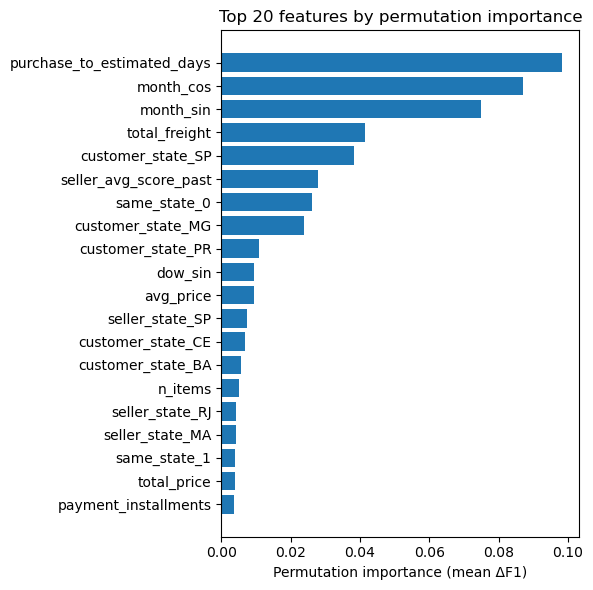

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

art = joblib.load("best_xgb_model_3_runs.pkl")
best_model   = art["model"]
preprocessor = art["preprocessor"]
X_test_pre   = art["X_test_pre"]
y_test       = art["y_test"]

num_features = numerical_features + ordinal_linear
ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
cyclic_feature_names = ["month_sin", "month_cos", "dow_sin", "dow_cos"]

feature_names = np.array(num_features + ohe_feature_names + cyclic_feature_names)

perm = permutation_importance(
    best_model,
    X_test_pre,
    y_test,
    scoring="f1",
    n_repeats=5,
    random_state=0,
    n_jobs=-1,
)

perm_mean = perm.importances_mean
perm_std  = perm.importances_std

df_perm_imp = pd.DataFrame({
    "feature": feature_names,
    "perm_importance_mean": perm_mean,
    "perm_importance_std": perm_std,
}).sort_values("perm_importance_mean", ascending=False)

print("\n=== Permutation importance on best-run TEST (top 20) ===")
print(df_perm_imp.head(20).to_string(index=False))

top_k = 20
top_perm = df_perm_imp.head(top_k)

plt.figure(figsize=(6, 6))
plt.barh(top_perm["feature"][::-1], top_perm["perm_importance_mean"][::-1])
plt.xlabel("Permutation importance (mean ΔF1)")
plt.title(f"Top {top_k} features by permutation importance")
plt.tight_layout()
plt.savefig("../figures/permutation.png", dpi=300, bbox_inches="tight")
plt.show()

Total feature dim: 66
X_test_pre shape : (19564, 66)

=== Gain-only importance ranking (top 20) ===
                      feature  gain_importance  gain_rank
            customer_state_SP         8.314161          1
                 same_state_1         7.842876          2
                 same_state_0         6.319328          3
              seller_state_MA         5.728328          4
                    month_cos         4.451772          5
            customer_state_MG         3.807522          6
            customer_state_AL         3.774021          7
                    month_sin         3.705177          8
   purchase_to_estimated_days         3.432017          9
            customer_state_PA         3.272492         10
            customer_state_BA         3.148172         11
            customer_state_RJ         3.137353         12
              seller_state_SP         3.078094         13
            customer_state_PR         3.075318         14
            customer_state_PE 

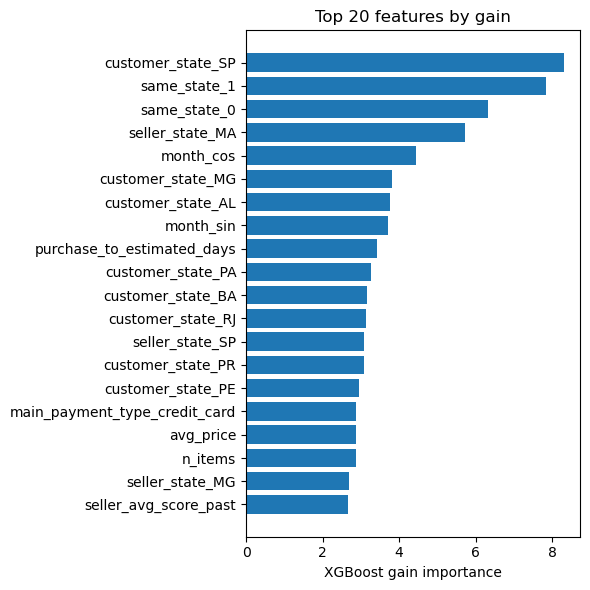


=== Full importance table (features that appear in any top-20) ===
                      feature  weight_importance  weight_rank  gain_importance  gain_rank  cover_importance  cover_rank  total_gain_importance  total_gain_rank  total_cover_importance  total_cover_rank
            customer_state_SP            10026.0           26         8.314161          1        490.517242           3           83357.781250               12            4.917926e+06                13
                 same_state_1              906.0           54         7.842876          2        434.538116           5            7105.645996               42            3.936915e+05                46
                 same_state_0             8532.0           30         6.319328          3        386.796448           8           53916.507812               15            3.300147e+06                24
              seller_state_MA             3914.0           41         5.728328          4        763.915405           1     

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

art         = joblib.load("best_xgb_model_3_runs.pkl")
best_model  = art["model"]
preprocessor = art["preprocessor"]
X_test_pre  = art["X_test_pre"]

num_features = numerical_features + ordinal_linear
ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
cyclic_feature_names = ["month_sin", "month_cos", "dow_sin", "dow_cos"]

feature_names = np.array(num_features + ohe_feature_names + cyclic_feature_names)
n_features = len(feature_names)
print("Total feature dim:", n_features)
print("X_test_pre shape :", X_test_pre.shape)

booster = best_model.get_booster()

gain_scores = booster.get_score(importance_type="gain")
gain_arr = np.array([gain_scores.get(f"f{j}", 0.0) for j in range(n_features)])
order_gain = np.argsort(-gain_arr)
gain_ranks = np.empty(n_features, dtype=int)
gain_ranks[order_gain] = np.arange(1, n_features + 1)

df_gain = pd.DataFrame({
    "feature": feature_names,
    "gain_importance": gain_arr,
    "gain_rank": gain_ranks,
}).sort_values("gain_rank")

print("\n=== Gain-only importance ranking (top 20) ===")
print(df_gain.head(20).to_string(index=False))

top_k = 20
top_idx_gain = order_gain[:top_k]

plt.figure(figsize=(6, 6))
plt.barh(feature_names[top_idx_gain][::-1], gain_arr[top_idx_gain][::-1])
plt.xlabel("XGBoost gain importance")
plt.title(f"Top {top_k} features by gain")
plt.tight_layout()
plt.savefig("../figures/xgb_gain_importance_top20.png", dpi=300, bbox_inches="tight")
plt.show()

imp_types = ["weight", "gain", "cover", "total_gain", "total_cover"]

imp_arrays = {}
rank_arrays = {}

for t in imp_types:
    scores_t = booster.get_score(importance_type=t)
    arr_t = np.array([scores_t.get(f"f{j}", 0.0) for j in range(n_features)])
    imp_arrays[t] = arr_t

    order_t = np.argsort(-arr_t)
    ranks_t = np.empty(n_features, dtype=int)
    ranks_t[order_t] = np.arange(1, n_features + 1)
    rank_arrays[t] = ranks_t
top_idx = set()
for t in imp_types:
    arr_t = imp_arrays[t]
    top20_t = np.argsort(-arr_t)[:20]
    top_idx.update(top20_t.tolist())
top_idx = sorted(top_idx)

data = {"feature": feature_names[top_idx]}
for t in imp_types:
    data[f"{t}_importance"] = imp_arrays[t][top_idx]
    data[f"{t}_rank"]       = rank_arrays[t][top_idx]

df_imp = pd.DataFrame(data)

df_imp = df_imp.sort_values(["gain_rank", "total_gain_rank"])

print("\n=== Full importance table (features that appear in any top-20) ===")
print(df_imp.to_string(index=False))

df_imp.to_csv("../results/xgb_feature_importances_multi_types.csv", index=False)
print("\nSaved importance table → ../results/xgb_feature_importances_multi_types.csv")

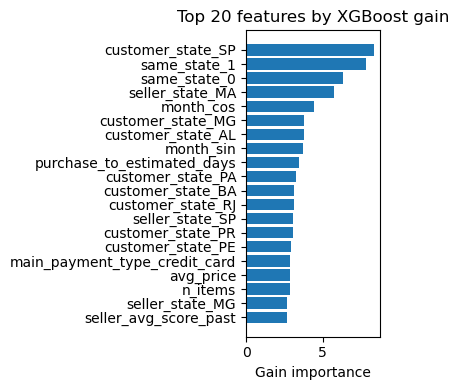

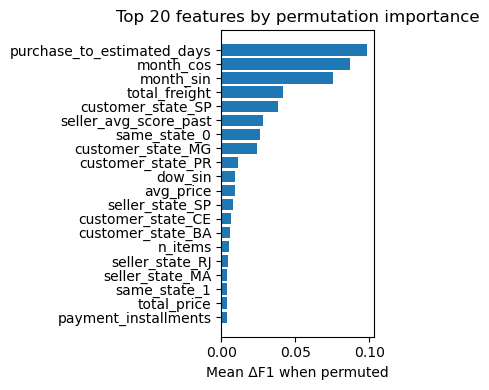

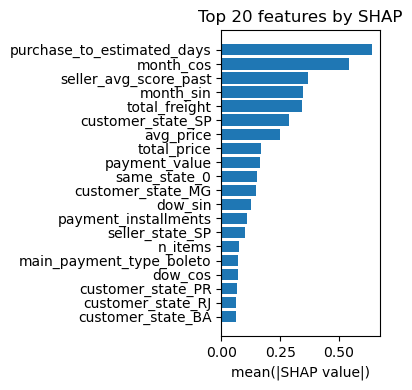

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap
import os
from sklearn.inspection import permutation_importance

os.makedirs("../figures", exist_ok=True)

# 读模型 + 数据（你已经在 pipeline 里存好了）
art         = joblib.load("best_xgb_model_3_runs.pkl")
best_model  = art["model"]
X_test_pre  = art["X_test_pre"]
y_test      = art["y_test"]

# 这里假定你前面已经像之前一样定义好了 feature_names
# feature_names = np.array(num_features + ohe_feature_names + cyclic_feature_names)
n_features = X_test_pre.shape[1]

# ========= 1. XGBoost 内置 gain importance =========
booster = best_model.get_booster()
gain_scores = booster.get_score(importance_type="gain")
gain_arr = np.array([gain_scores.get(f"f{j}", 0.0) for j in range(n_features)])

# ========= 2. Permutation importance (ΔF1) =========
perm = permutation_importance(
    best_model,
    X_test_pre,
    y_test,
    scoring="f1",
    n_repeats=5,
    random_state=0,
    n_jobs=-1,
)
perm_mean = perm.importances_mean

# ========= 3. SHAP global importance: mean(|SHAP value|) =========
# 取一部分样本加速
rng = np.random.RandomState(0)
n_sample = min(2000, X_test_pre.shape[0])
idx = rng.choice(X_test_pre.shape[0], size=n_sample, replace=False)
X_shap = X_test_pre[idx]

explainer    = shap.TreeExplainer(best_model)
shap_values  = explainer.shap_values(X_shap)
if isinstance(shap_values, list):
    shap_values_pos = shap_values[1]
else:
    shap_values_pos = shap_values

shap_mean_abs = np.mean(np.abs(shap_values_pos), axis=0)  # 每个特征的 mean(|SHAP|)

# ========= 统一画 Top-20 bar 图 =========
def plot_topk_bar(values, feature_names, title, xlabel, filename, k=20):
    order = np.argsort(values)[-k:]      # 取最大的 k 个
    order = order[::-1]                  # 从大到小画
    plt.figure(figsize=(4, 4))
    plt.barh(feature_names[order], values[order])
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# 1) gain
plot_topk_bar(
    gain_arr,
    feature_names,
    "Top 20 features by XGBoost gain",
    "Gain importance",
    "../figures/global_importance_gain_top20.png",
)

# 2) permutation ΔF1
plot_topk_bar(
    perm_mean,
    feature_names,
    "Top 20 features by permutation importance",
    "Mean ΔF1 when permuted",
    "../figures/global_importance_permutation_top20.png",
)

# 3) SHAP mean(|value|)
plot_topk_bar(
    shap_mean_abs,
    feature_names,
    "Top 20 features by SHAP",
    "mean(|SHAP value|)",
    "../figures/global_importance_shap_top20.png",
)

True label: 0
Predicted P(late=1): 0.04925715923309326


/var/folders/ff/5t6ph_yd6j1clj5h31xk43fc0000gn/T/ipykernel_49401/2575018031.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(best_model.predict_proba(x0)[:, 1]))


<Figure size 1000x250 with 0 Axes>

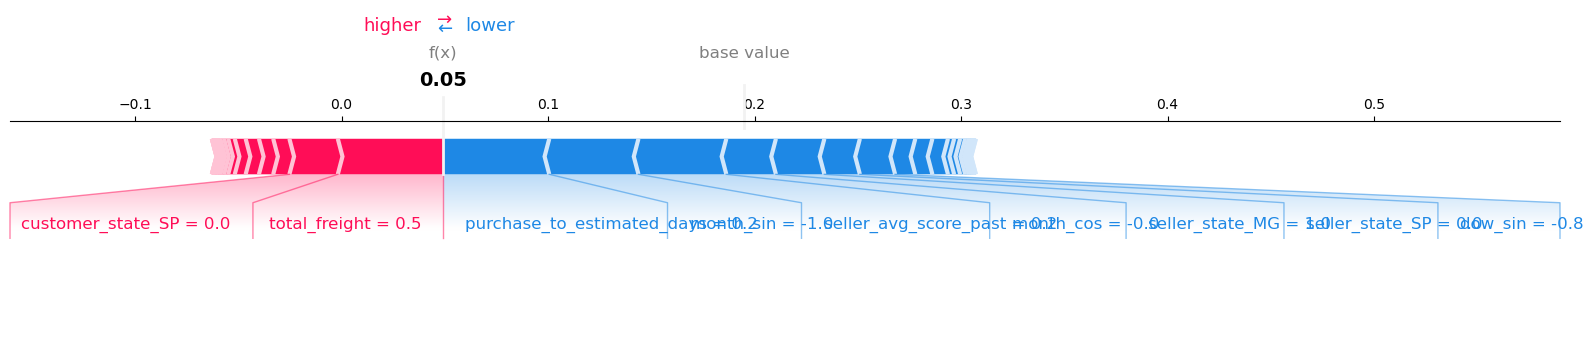

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import shap

shap.initjs()  # for JS-based plots (not needed for matplotlib=True)

art = joblib.load("best_xgb_model_3_runs.pkl")
best_model   = art["model"]
preprocessor = art["preprocessor"]
X_test_pre   = art["X_test_pre"]
y_test       = art["y_test"]

num_features = numerical_features + ordinal_linear
ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
cyclic_feature_names = ["month_sin", "month_cos", "dow_sin", "dow_cos"]
feature_names = np.array(num_features + ohe_feature_names + cyclic_feature_names)

os.makedirs("../figures", exist_ok=True)

# 选一个样本，比如第 250 行
idx = 250
x0  = X_test_pre[idx:idx+1]   # 保持 2D
print("True label:", y_test.iloc[idx])
print("Predicted P(late=1):",
      float(best_model.predict_proba(x0)[:, 1]))

# ===== 用“所有数据”做背景集 =====
X_background = X_test_pre    # 不再抽样，直接全用

explainer = shap.TreeExplainer(
    best_model,
    data=X_background,
    model_output="probability"   # SHAP 解释的是 P(y=1)
)
shap_values = explainer.shap_values(x0)

if isinstance(shap_values, list):
    shap_values_pos = shap_values[1]     # 解释“晚到=1”这一类
    expected_pos    = explainer.expected_value[1]
else:
    shap_values_pos = shap_values
    expected_pos    = explainer.expected_value

# 只取这个样本的 shap 向量
sv = shap_values_pos[0]          # shape: (n_features,)
x0_flat = x0[0]

# 选 top-K 绝对值最大的特征（避免太挤）
top_k = 67
top_idx = np.argsort(np.abs(sv))[::-1][:top_k]

sv_top        = sv[top_idx]
x0_top        = x0_flat[top_idx]
feat_top      = feature_names[top_idx]

# 数值四舍五入到 1 位小数（one-hot 基本就是 0/1）
x0_top_rounded = np.round(x0_top.astype(float), 1)

plt.figure(figsize=(10, 2.5))
shap.force_plot(
    expected_pos,
    sv_top,
    features=x0_top_rounded,
    feature_names=feat_top,
    matplotlib=True,
    show=False,
)
plt.savefig("../figures/shap_force_example_idx250_top7_allbg.png",
            dpi=300, bbox_inches="tight")
plt.show()

True label: 0
Predicted P(late=1): 0.04925715923309326


/var/folders/ff/5t6ph_yd6j1clj5h31xk43fc0000gn/T/ipykernel_49401/3222872632.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(best_model.predict_proba(x0)[:, 1]))


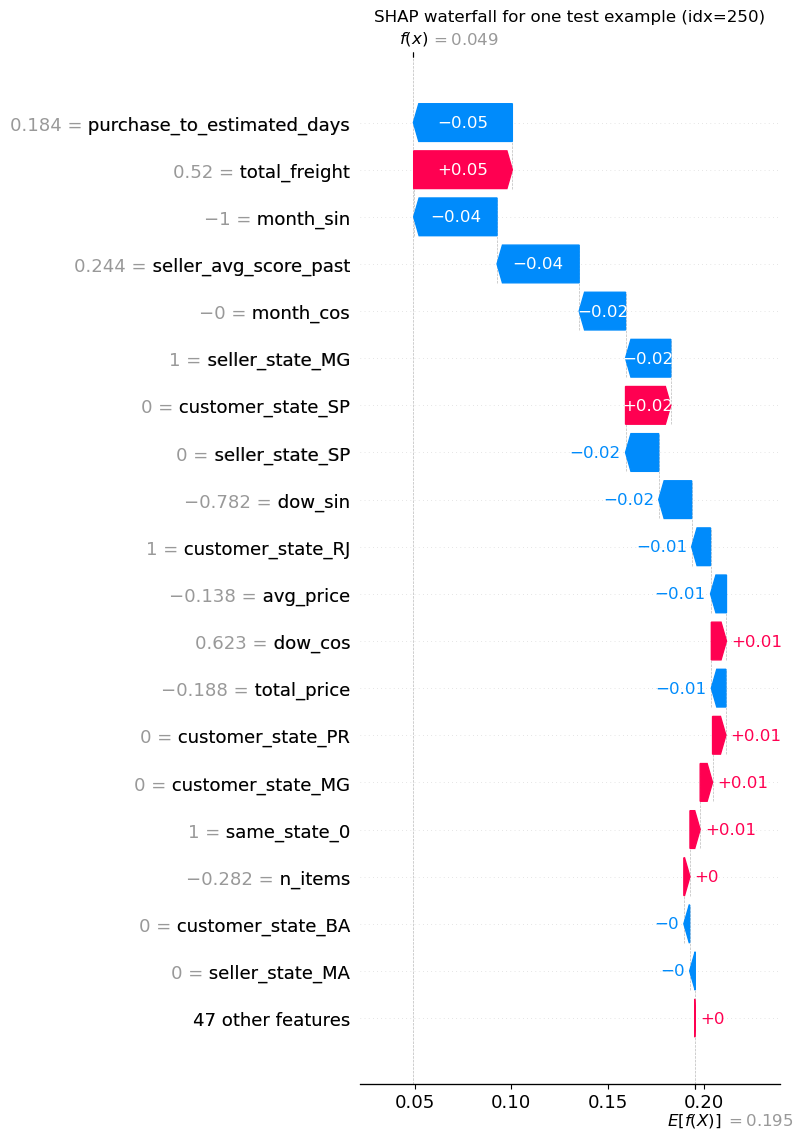

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import shap

# ---- 1. 读取模型与数据 ----
art = joblib.load("best_xgb_model_3_runs.pkl")
best_model   = art["model"]
preprocessor = art["preprocessor"]
X_test_pre   = art["X_test_pre"]
y_test       = art["y_test"]

# 这里假设你之前已经在 notebook 里定义过这几个列表：
# numerical_features, ordinal_linear, categorical_features
num_features = numerical_features + ordinal_linear
ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
cyclic_feature_names = ["month_sin", "month_cos", "dow_sin", "dow_cos"]
feature_names = np.array(num_features + ohe_feature_names + cyclic_feature_names)

os.makedirs("../figures", exist_ok=True)

# ---- 2. 选一个要解释的样本 ----
# 换成你想解释的 index，比如错分的、预测 P(late) 很高的那一行
idx = 250
x0  = X_test_pre[idx:idx+1]     # 保持 2D
print("True label:", y_test.iloc[idx])
print("Predicted P(late=1):",
      float(best_model.predict_proba(x0)[:, 1]))

# ---- 3. 建 TreeExplainer（用概率作为输出）----
# 背景集可以用全部 test，也可以抽一部分；这里用全部 test_pre
X_background = X_test_pre

explainer = shap.TreeExplainer(
    best_model,
    data=X_background,
    model_output="probability"   # 解释 P(y=1) 而不是 logit
)
shap_values = explainer.shap_values(x0)

# XGBoost + TreeExplainer 可能返回 list（每个类一个数组），也可能直接返回 ndarray
if isinstance(shap_values, list):
    # 二分类：第 1 个类对应 “late=1”
    sv = shap_values[1][0]          # (n_features,)
    base_value = explainer.expected_value[1]
else:
    sv = shap_values[0]
    base_value = explainer.expected_value

x0_flat = x0[0]  # (n_features,)

# ---- 4. 构造 SHAP Explanation 对象 ----
# waterfall_plot 需要一个 Explanation
exp = shap.Explanation(
    values=sv,                    # 每个特征的 SHAP value（对 P(late=1) 的贡献）
    base_values=base_value,       # E[P(late=1)]，基线概率
    data=x0_flat,                 # 该样本在各特征空间里的取值
    feature_names=feature_names
)

# ---- 5. 画 waterfall 图并保存 ----
plt.figure(figsize=(8, 6))
shap.plots.waterfall(exp, max_display=20, show=False)  # 只显示 top 10 特征
plt.title(f"SHAP waterfall for one test example (idx={idx})")
plt.tight_layout()
plt.savefig("../figures/shap_waterfall_idx250_top10.png",
            dpi=300, bbox_inches="tight")
plt.show()

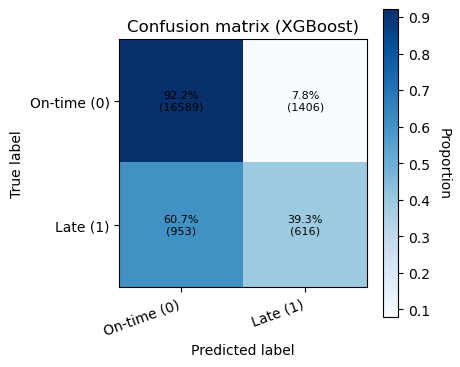

In [ ]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 读入最优模型及数据
art = joblib.load("best_xgb_model_3_runs.pkl")
y_test = art["y_test"]
y_pred = art["y_test_pred"]

classes = ["On-time (0)", "Late (1)"]

# 先算原始 cm（用来当文字标签）
cm_counts = confusion_matrix(y_test, y_pred)

# 再算归一化 cm（每一行和为 1）
cm_norm = confusion_matrix(y_test, y_pred, normalize="true")

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm_norm, interpolation="nearest", cmap="Blues")

ax.set_title("Normalized confusion matrix (XGBoost, best run)")
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=20, ha="right")
ax.set_yticklabels(classes)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

# 加 colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Proportion", rotation=270, labelpad=15)

# 在格子里标注：百分比 + 原始个数
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        pct = cm_norm[i, j] * 100
        cnt = cm_counts[i, j]
        ax.text(
            j, i,
            f"{pct:.1f}%\n({cnt})",
            ha="center",
            va="center",
            fontsize=8,
        )

plt.savefig(
    "../figures/confusion_matrix_xgb_best_normalized.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

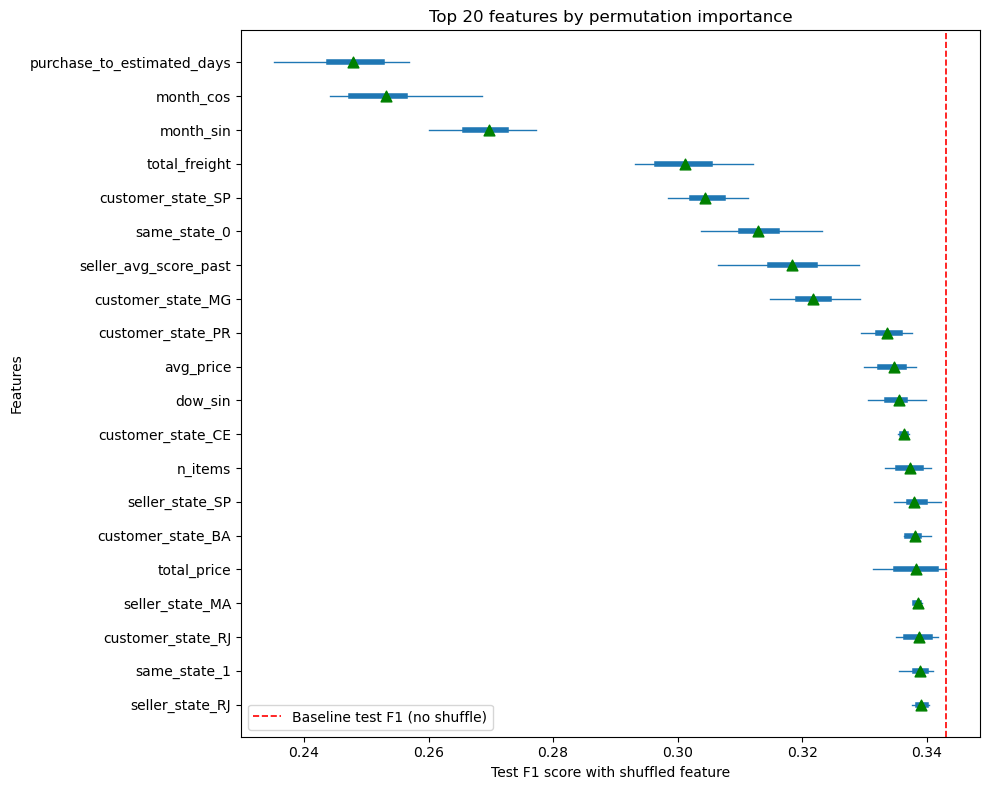

In [40]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

art = joblib.load("best_xgb_model_3_runs.pkl")
best_model   = art["model"]
preprocessor = art["preprocessor"]
X_test_pre   = art["X_test_pre"]
y_test       = art["y_test"]

num_features = numerical_features + ordinal_linear
ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
cyclic_feature_names = ["month_sin", "month_cos", "dow_sin", "dow_cos"]
feature_names = np.array(num_features + ohe_feature_names + cyclic_feature_names)
n_features = len(feature_names)

os.makedirs("../figures", exist_ok=True)

y_test_pred = best_model.predict(X_test_pre)
baseline_f1 = f1_score(y_test, y_test_pred)

perm = permutation_importance(
    best_model,
    X_test_pre,
    y_test,
    scoring="f1",
    n_repeats=20,
    random_state=0,
    n_jobs=-1,
)

imp_raw = perm.importances
f1_shuffled = baseline_f1 - imp_raw
mean_drop = perm.importances_mean

top_k = 20
top_idx = np.argsort(-mean_drop)[:top_k]

feature_names_top = feature_names[top_idx]
f1_shuffled_top   = f1_shuffled[top_idx, :]

fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(top_k)

for i in range(top_k):
    vals = f1_shuffled_top[i, :]
    q1, q3 = np.percentile(vals, [25, 75])
    iqr = q3 - q1
    whisk_low  = vals[vals >= q1 - 1.5 * iqr].min()
    whisk_high = vals[vals <= q3 + 1.5 * iqr].max()

    ax.plot([q1, q3], [y_pos[i], y_pos[i]], linewidth=4, color="tab:blue")
    ax.plot([whisk_low, q1],  [y_pos[i], y_pos[i]], linewidth=1, color="tab:blue")
    ax.plot([q3, whisk_high], [y_pos[i], y_pos[i]], linewidth=1, color="tab:blue")

    mean_val = vals.mean()
    ax.scatter(mean_val, y_pos[i], marker="^", s=60, color="green", zorder=3)

ax.axvline(
    baseline_f1,
    color="red",
    linestyle="--",
    linewidth=1.2,
    label="Baseline test F1 (no shuffle)",
)

ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names_top)
ax.set_xlabel("Test F1 score with shuffled feature")
ax.set_ylabel("Features")
ax.set_title("Top 20 features by permutation importance")
ax.legend(loc="lower left")

ax.invert_yaxis()  

plt.tight_layout()
plt.savefig("../figures/perm_boxplot_top20.png", dpi=300, bbox_inches="tight")
plt.show()

In [5]:
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

art = joblib.load("best_xgb_model_3_runs.pkl")

model = art["model"]
thr   = float(art["best_threshold"])

X_train = art["X_train_pre"]
y_train = art["y_train"]

X_val = art["X_val_pre"]
y_val = art["y_val"]

X_test = art["X_test_pre"]
y_test = art["y_test"]

def eval_with_threshold(name, X, y, thr):
    proba = model.predict_proba(X)[:, 1]
    pred  = (proba >= thr).astype(int)

    acc  = accuracy_score(y, pred)
    prec = precision_score(y, pred, zero_division=0)
    rec  = recall_score(y, pred, zero_division=0)
    f1   = f1_score(y, pred)

    print(f"\n== {name} (thr={thr:.2f}) ==")
    print(f"Acc : {acc:.4f}")
    print(f"Prec: {prec:.4f}")
    print(f"Rec : {rec:.4f}")
    print(f"F1  : {f1:.4f}")

print("Using shared threshold from artifact:", thr)

eval_with_threshold("TRAIN", X_train, y_train, thr)
eval_with_threshold("VAL",   X_val,   y_val,   thr)
eval_with_threshold("TEST",  X_test,  y_test,  thr)

Using shared threshold from artifact: 0.49999999999999994

== TRAIN (thr=0.50) ==
Acc : 0.9601
Prec: 0.6696
Rec : 0.9923
F1  : 0.7996

== VAL (thr=0.50) ==
Acc : 0.8784
Prec: 0.3009
Rec : 0.3901
F1  : 0.3397

== TEST (thr=0.50) ==
Acc : 0.8794
Prec: 0.3046
Rec : 0.3926
F1  : 0.3431
